## DOE ARM SGP 30QCECOR Analysis (Cropwise)
### Latent heat flux analysis as a function of surface conditions (vegetation type, etc.) reported in ARM Preventative Maintenance (PM) reports 

##### Written by Sid Gupta (sid.gupta@anl.gov) - last updated September, 2025
- Reviewed by Adam Theisen for upload to ARM-FLUX-VEG repository.
  
The authors acknowledge the contributions of the site operations staff for their dedicated efforts in manually collecting and curating vegetation information. These measurements were integral to the development and production of this data product.

#### Introduction

This notebook deals with Eddy Correlation Flux Measurement System (ECOR) data from the ARM Southern Great Plains (SGP) facility sites. Preventative Maintenance (PM) reports provide site operator responses to preset questions about vegetation and surface conditions. These responses can supplement the ECOR measurements to provide ground truth. These responses can be subjective, and thus they are provided here in place of an ARM datastream. 

Data from old PM reports until 2020 were compiled into a single file. The notebook describes how data from the biweekly PM reports can be used along with the ECOR datastream. Please see the instrument webpage for the Eddy Correlation Flux Measurement System (ECOR) (https://www.arm.gov/capabilities/instruments/ecor). In October 2019, the ECOR systems at SGP were upgraded with newer-model instruments, including the addition of a microprocessor allowing both uncorrected and corrected fluxes in a single datastream, ECORSF. A separate notebook is provided for using the ECORSF datastream. 

Uncorrected turbulent fluxes are available in the 30ecor datastream. It is recommended that routine ECOR corrections are applied to the data prior to use, and corrected fluxes are available in the 30qcecor VAP. This notebook deals with pre-2019 ECOR data (30ECOR) and surface/vegetation conditions. In the 30ECOR datastream, there are known issues with the CO$_2$ flux measurements and this notebook concerns only the latent heat flux.

This notebook also uses Surface Energy Balance System (SEBS) data for soil moisture content.

Notes:
- S4, S5, and S6 were only deployed temporarily for the AWAKEN field campaign - there are not too many PM reports for these sites after the campaign. 
- PM reports are provided biweekly, and it is assumed surface conditions did not vary considerably over the two week period. With this assumption, ECOR data from the preceding two weeks can be associated with the PM report. Thus, one can analyze flux measurements as a function of vegetation type, condition, color, etc.
- This notebook helps identify sites with most PM reports; commonly reported crop types and surface conditions, etc. The notebook provides examples for plots of trends in CO$_2$ or latent heat fluxes as a function of the crop types and vegetation/soil conditions.

#### Notebook Contents
- Find most frequently reported vegetation conditions
- Calculate flux by vegetation type
- Retrieve ECOR data for the timings associated with these conditions
- Find variability in flux data based on variable conditions within these timings


In [1]:
import xarray as xr
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
import act
import glob

C:\Users\sid.gupta\AppData\Local\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\sid.gupta\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\sid.gupta\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


### Load PM reports data

In [2]:
sfccond=pd.read_excel('SGP_Surface_Conditions.xlsx')
sfccond.keys()

Index(['Timeon', 'Sitename', 'Date', 'Name', 'tvlA', 'tvlB', 'tvlC', 'tvlD',
       'tvlE', 'hinside', 'houtside', 'ecunan', 'pasrg', 'ecvt2', 'ecvt1',
       'mbs', 'wwh', 'wwhlst', 'rcrp', 'rctyp', 'rctyp1', 'ecvcon', 'ecsoil',
       'ecmoist', 'echt', 'vhifmos', 'vhofmos', 'Comments'],
      dtype='object')

Variable long names (along with most common responses):

- Name - Technician name
- tvlA - Type of vegetation (Mostly clumped grass, Mostly uniform grass)
- tvlB - Type of vegetation (Derived from grazed grasslands, Native prairie) 
- tvlC - Vegetation condition ('Brown due to freezing conditions', 'Lush green, unwilted', 'Green w/brown patches because of hot, dry weather', 'Mostly brown due to hot, dry weather','Fully green but noticeably wilted')
- tvlD - Surface soil conditions ('Dry and dusty', 'Moist but not muddy', 'Muddy or standing water')
- tvlE - Moisture on vegetation (or soil if no vegetation) ('Dry', 'Slightly wet because of rain or dew', 'Mostly wet because of rain or dew')
- hinside - Approximate height of vegetation inside fence
- houtside - Approximate height of vegetation outside but near fence


Only for sites with Eddy Correlation (EC) stations:
- ecunan - Unanticipated vegetation condition (mostly No)
- pasrg - Pasture or rangeland (No: 3943, Yes: 922)
- ecvt2 - Type of vegetation ('Derived from grazed grasslands', 'Native prairie', 'Forest Covered')
- ecvt1 - Type of vegetation ('Mostly clumped grass', 'Mostly uniform grass', 'Forest Covered', 'Woods') 
- mbs - Mostly bare soil (Yes, No)
- wwh - Winter wheat (Yes, No)
- wwhlst - Winter wheat condition ('Green, ground covered','Partial soil coverage because plants are small','Stubble after harvest','Stubble mostly covered with green weeds after harvest','Yellow but unharvested')
- rcrp - Row crops (Yes, No)
- rctyp - Row crop type ('Alfalfa', 'Soybeans', 'Corn', 'Other Row Crop (see comments)','Sorghum', 'Milo')
- rctyp1 - Row crop type ('Green, ground covered', 'Only debris left after harvest','Yellow but unharvested', 'Partial soil coverage because plants small')
- ecvcon - Vegetation condition ('Lush green, unwilted', 'Brown due to freezing conditions','All or mostly bare soil', 'Mostly brown due to hot, dry weather','Green with brown patches because of hot, dry weather','Fully green but noticeably wilted')
- ecsoil - Surface soil conditions ('Dry and dusty', 'Moist but not muddy', 'Muddy or standing water')
- ecmoist - Moisture on vegetation or soil ('Dry', 'Slightly wet because of rain or dew', 'Mostly wet because of rain or dew', '0-25% snow covered')
- echt - Approximate height of vegetation

Only at extended facilities with EBBR stations

- vhifmos - Vegetation inside fence is mostly (Grassy, Broadleaf)
- vhofmos - Vegetation outside fence is mostly (Grassy, Broadleaf)

#### Identify the most commonly reported crop types

In [32]:
# sfccond[['rcrp','Sitename']].value_counts() # Identify crop type as a function of sites
sfccond[sfccond['rcrp']=='Yes']['rctyp'].value_counts()[0:6]

rctyp
Alfalfa                          358
Soybeans                         332
Corn                             198
Other Row Crop (see comments)     85
Sorghum                           74
Milo                              44
Name: count, dtype: int64

In [4]:
# site_conditions=sfccond[(sfccond['Sitename']=='E3 LeRoy') & (sfccond['rcrp']=='Yes')]
# site_conditions = site_conditions_all[site_conditions_all['rctyp']=='Alfalfa']

### Download 30ECOR and Surface Energy Balance System (SEBS) data for two weeks leading up to each PM report
- To limit the processing time, one can reduce the time period for which data are downloaded for each PM report, the default is 13 days (2 weeks including the report date)

In [5]:
# Data are downloaded using the DOE ACT software package (see https://arm-doe.github.io/ACT/API/generated/act.discovery.download_arm_data.html)

# Set your ARM Live data username and password (see instructions on ACT link above)
username = ''
token = ''

In [16]:
# Mention a single crop from the list
# Downloading and processing data for multiple crops together is not recommended due to download time and file volumes
# Note that winter wheat has a separate variable to indicate its presence (wwh = Yes) , rest of the crops are indicated separately (rcrp=Yes)

crops = ['Alfalfa'] # WW, Alfalfa, Soybeans, Corn, Sorghum, Milo

# Number of days to extend back from report date; using 13 since PM reports are biweekly
interval=13

# Create a dataframe that only has PM reports where row crops were reported
site_conditions_all=sfccond[sfccond['rcrp']=='Yes']

# Iterate over the PM reports that reported the selected crop/winter wheat, identify the sites with these crops
for crop in crops:
    print(crop)
    if crop=='WW':
        site_conditions = sfccond[sfccond['wwh']=='Yes']
    else:
        site_conditions = site_conditions_all[site_conditions_all['rctyp']==crop]
    sites=site_conditions['Sitename'].values
        
    for k in range(0,len(site_conditions)): # len(site_conditions)
        
        site=sites[k]
        if site[2]==' ':
            sitename=site[0:2]
        else:
            sitename=site[0:3]
        
        datastream_qcecor = 'sgp30qcecor'+sitename+'.c1'
        datastream_ecor = 'sgp30ecor'+sitename+'.b1'
        datastream_sebs = 'sgpsebs'+sitename+'.b1'
        startdate=(pd.to_datetime(site_conditions.Date.values[k])-pd.Timedelta(interval,'d')).strftime('%Y%m%d')
        enddate=pd.to_datetime(site_conditions.time.values[k]).strftime('%Y%m%d')

        # qcecor_files = act.discovery.download_arm_data(username, token, datastream_qcecor, startdate, enddate)        
        # ecor_files = act.discovery.download_arm_data(username, token, datastream_ecor, startdate, enddate)        
        # sebs_files = act.discovery.download_arm_data(username, token, datastream_sebs, startdate, enddate)        
        
        if len(glob.glob('sgpsebs'+sitename+'.b1/*'+startdate+'*'))>0 or \
        len(glob.glob('sgpsebs'+sitename+'.b1/*'+enddate+'*'))>0:
            print('sgpsebs'+sitename+'.b1 for start ('+startdate+') or end ('+enddate+') found, not attempting to download this 2-week period')
        else:        
            sebs_files = act.discovery.download_arm_data(username, token, datastream_sebs, startdate, enddate)        

        if len(glob.glob('sgpecor'+sitename+'.b1/*'+startdate+'*'))>0 or \
        len(glob.glob('sgpecor'+sitename+'.b1/*'+enddate+'*'))>0:
            print('sgpecor'+sitename+'.b1 for start ('+startdate+') or end ('+enddate+') found, not attempting to download this 2-week period')
        else:        
            ecor_files = act.discovery.download_arm_data(username, token, datastream_ecor, startdate, enddate)        

        if len(glob.glob('sgpqcecor'+sitename+'.c1/*'+startdate+'*'))>0 or \
        len(glob.glob('sgpqcecor'+sitename+'.c1/*'+enddate+'*'))>0:
            print('sgpqcecor'+sitename+'.c1 for start ('+startdate+') or end ('+enddate+') found, not attempting to download this 2-week period')
        else:        
            qcecor_files = act.discovery.download_arm_data(username, token, datastream_qcecor, startdate, enddate)        

Alfalfa
No files returned or url status error.
Check datastream name, start, and end date. 

No files returned or url status error.
Check datastream name, start, and end date. 

No files returned or url status error.
Check datastream name, start, and end date. 

No files returned or url status error.
Check datastream name, start, and end date. 

No files returned or url status error.
Check datastream name, start, and end date. 

No files returned or url status error.
Check datastream name, start, and end date. 

No files returned or url status error.
Check datastream name, start, and end date. 

No files returned or url status error.
Check datastream name, start, and end date. 

No files returned or url status error.
Check datastream name, start, and end date. 

No files returned or url status error.
Check datastream name, start, and end date. 

No files returned or url status error.
Check datastream name, start, and end date. 

No files returned or url status error.
Check datastream n

### Concatenate biweekly data for each PM report. This part of the code will take some time since some sites can often have PM reports spanning multiple years. Please run this cell for a single site at one time.
#### Retrieve daily data files (with 30-min time resolution)
#### Apply Quality Control Flag
#### Apply Wind Direction check 
- ECOR stations are located over a variety of vegetation types including cropland, grassland, and forest, depending on site and prevailing wind direction. Users should be aware of the surface type representation when using the turbulent flux measurements from ECOR and EBBR. More information about site-specific vegetation type can be found in the ECOR instrument handbook (https://www.arm.gov/publications/tech_reports/handbooks/ecor_handbook.pdf). Wind directions that are not listed are directions for which the fetch is insufficient, and therefore, for which the ECOR flux data are suspect and have to be discarded.
- Create variables (co2_ or latent_flux_site_date) for each date.
- Concatenate these variables into a single variable per PM report (i.e., concatenate 2 weeks worth of data into one file for each PM report)
- The data are reported every 30 minutes, so each date should have up to 48 measurements. Some of these are removed due to the QC flag or wind direction.

#### Output:
- variable_site_date: Daily measurements for a specific site for a specific date
- variable_biweekly_site_date: Daily measurements for a specific site for a two-week period ending in the date of each PM report
- variable: Average value of the biweekly measurements; added to the dataframe associated to each site for box plots
The daily measurement variables are useful for the time series plots further below. The average values are useful for box-whisker plots below. Users can save the site-specific dataframes to create box-whisker plots later without running the entire notebook. Doing so for daily measurements would create a large number of additional files and is not done currently. 

#### Process soil moisture data

In [18]:
crops = ['Alfalfa'] # WW, Alfalfa, Soybeans, Corn, Sorghum, Milo
interval=13
site_conditions_all=sfccond[sfccond['rcrp']=='Yes']

for crop in crops:
    print(crop)
    if crop=='WW':
        site_conditions = sfccond[sfccond['wwh']=='Yes']
    else:
        site_conditions = site_conditions_all[site_conditions_all['rctyp']==crop]
    sites=site_conditions['Sitename'].values

    for k in range(0,len(site_conditions)): # len(site_conditions)
        startdate=(pd.to_datetime(site_conditions.Date.values[k])-pd.Timedelta(interval,'d')).strftime('%Y%m%d')
        enddate=pd.to_datetime(site_conditions.Date.values[k]).strftime('%Y%m%d')             
        
        site=sites[k]
        if site[2]==' ':
            sitename=site[0:2]
        else:
            sitename=site[0:3]    

        files=[]
        dates=[]               

        for jj in range(interval,-1,-1):
            date=(pd.to_datetime(site_conditions.Date.values[k])-pd.Timedelta(jj,'d')).strftime('%Y%m%d')
            file = glob.glob('sgpsebs'+sitename+'.b1/*'+date+'*')

            # if os.path.exists(r'C:\Users\sid.gupta\Documents\data\fluxes\sgpsebs'+sitename+'.b1/sgpsebs'+sitename+'.b1.'+date+'.000000.cdf')==True:
            if len(file)>0:     
                sebsdata=xr.open_dataset(file[0])
                soilmoisture1=sebsdata.soil_moisture_1.where(sebsdata.qc_soil_moisture_1==0).values
                soilmoisture2=sebsdata.soil_moisture_2.where(sebsdata.qc_soil_moisture_2==0).values
                soilmoisture3=sebsdata.soil_moisture_3.where(sebsdata.qc_soil_moisture_3==0).values
                soilmoisture=sebsdata.soil_moisture_3;soilmoisture=soilmoisture.rename('averaged_soil_moisture')
                soilmoisture.attrs['long_name']='Averaged Soil Moisture'
                soilmoisture.values=np.nanmean(np.array([soilmoisture1,soilmoisture2,soilmoisture3]),axis=0)
                globals()['soil_moisture_{}_{}'.format(sitename,date)]=soilmoisture

        # Create a single concatenated variable for each PM report with data from all corresponding dates
                dates.append(date)
                files.append(glob.glob('sgpsebs'+sitename+'.b1/*'+date+'*'))        
                
        if len(files)>0:
            for kk in range(0,len(files)):
                if kk==0:
                    globals()['soil_moisture_biweekly_{}_{}'.format(sitename,enddate)]=globals()['soil_moisture_{}_{}'.format(sitename,dates[kk])]
                    print('{} has {} data points'.format(dates[kk],len(globals()['soil_moisture_{}_{}'.format(sitename,dates[kk])])))
                else:
                    globals()['soil_moisture_biweekly_{}_{}'.format(sitename,enddate)]=\
                    xr.concat([globals()['soil_moisture_biweekly_{}_{}'.format(sitename,enddate)],\
                              globals()['soil_moisture_{}_{}'.format(sitename,dates[kk])]],'time') 
                    print('{} has {} data points'.format(dates[kk],len(globals()['soil_moisture_{}_{}'.format(sitename,dates[kk])])))
            print('soil moisture files created for {}-{}'.format(sitename,enddate))  
        else:
            print('no soil moisture files for 2-week period related to {}-{}'.format(sitename,enddate))

Alfalfa
no soil moisture files for 2-week period related to E6-20000510
no soil moisture files for 2-week period related to E10-19980106
no soil moisture files for 2-week period related to E24-19980421
no soil moisture files for 2-week period related to E6-19980611
no soil moisture files for 2-week period related to E6-19980625
no soil moisture files for 2-week period related to E6-19980917
no soil moisture files for 2-week period related to E6-19981001
no soil moisture files for 2-week period related to E6-19990512
no soil moisture files for 2-week period related to E6-19990527
no soil moisture files for 2-week period related to E6-19990609
no soil moisture files for 2-week period related to E6-19990623
no soil moisture files for 2-week period related to E6-19990707
no soil moisture files for 2-week period related to E10-19990707
no soil moisture files for 2-week period related to E6-19990721
no soil moisture files for 2-week period related to E6-19990804
no soil moisture files for 2-

#### Process flux data

In [22]:
crops = ['Alfalfa'] # WW, Alfalfa, Soybeans, Corn, Sorghum, Milo
interval=13
site_conditions_all=sfccond[sfccond['rcrp']=='Yes']

for crop in crops:
    print(crop)
    if crop=='WW':
        site_conditions = sfccond[sfccond['wwh']=='Yes']
    else:
        site_conditions = site_conditions_all[site_conditions_all['rctyp']==crop]
    sites=site_conditions['Sitename'].values

    for k in range(190,len(site_conditions)): # len(site_conditions)
        startdate=(pd.to_datetime(site_conditions.Date.values[k])-pd.Timedelta(interval,'d')).strftime('%Y%m%d')
        enddate=pd.to_datetime(site_conditions.Date.values[k]).strftime('%Y%m%d')                
        
        site=sites[k]
        if site[2]==' ':
            sitename=site[0:2]
        else:
            sitename=site[0:3]    

        files=[]
        dates=[]     
                
        for jj in range(interval,-1,-1):
            date=(pd.to_datetime(site_conditions.Date.values[k])-pd.Timedelta(jj,'d')).strftime('%Y%m%d')
            file1 = glob.glob('sgp30qcecor'+sitename+'.c1/*'+date+'*')
            file2 = glob.glob('sgp30ecor'+sitename+'.b1/*'+date+'*')

            if len(file1)>0:            
                # Apply QC flag
                fluxdata=xr.open_dataset(file1[0])
                latent_flux_1=fluxdata.corrected_latent_heat_flux.where(fluxdata.qc_corrected_latent_heat_flux==0)
                co2_flux_1=fluxdata.corrected_co2_flux.where(fluxdata.qc_corrected_co2_flux==0)

                if len(file2)>0:            
                    # Apply wind direction dependency 
                    ecordata=xr.open_dataset(file2[0])
                    wdir=ecordata.wind_dir

                    if sitename=='E3':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where(np.logical_or((wdir>0) & (wdir<48),(wdir>132) & (wdir<260))).dropna('time')
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where(np.logical_or((wdir>0) & (wdir<48),(wdir>132) & (wdir<260))).dropna('time')
                    elif sitename=='E6':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where((wdir>0) & (wdir<360)).dropna('time')
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where((wdir>0) & (wdir<360)).dropna('time')
                    elif sitename=='E5':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where(np.logical_or((wdir>80) & (wdir<154),(wdir>154) & (wdir<260))).dropna('time')                    
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where(np.logical_or((wdir>80) & (wdir<154),(wdir>154) & (wdir<260))).dropna('time')                                        
                    elif sitename=='E39':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where(np.logical_or(np.logical_or((wdir>0) & (wdir<80),(wdir>100) & (wdir<260)),(wdir>280) & (wdir<360))).dropna('time')
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where(np.logical_or(np.logical_or((wdir>0) & (wdir<80),(wdir>100) & (wdir<260)),(wdir>280) & (wdir<360))).dropna('time')
                    elif sitename=='E37':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where(np.logical_or((wdir>135) & (wdir<260),(wdir>280) & (wdir<310))).dropna('time')
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where(np.logical_or((wdir>135) & (wdir<260),(wdir>280) & (wdir<310))).dropna('time')
                    elif sitename=='E33':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where(np.logical_or((wdir>100) & (wdir<300),(wdir>40) & (wdir<80))).dropna('time')
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where(np.logical_or((wdir>100) & (wdir<300),(wdir>40) & (wdir<80))).dropna('time')
                    elif sitename=='E31':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where(np.logical_or((wdir>100) & (wdir<200),(wdir>30) & (wdir<80))).dropna('time')
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where(np.logical_or((wdir>100) & (wdir<200),(wdir>20) & (wdir<80))).dropna('time')            
                    elif sitename=='E14':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where(np.logical_or(np.logical_or((wdir>0) & (wdir<85),(wdir>129) & (wdir<265)),(wdir>352) & (wdir<360))).dropna('time')
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where(np.logical_or(np.logical_or((wdir>0) & (wdir<85),(wdir>129) & (wdir<265)),(wdir>352) & (wdir<360))).dropna('time')
                    elif sitename=='E41':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where(np.logical_or(np.logical_or((wdir>0) & (wdir<80),(wdir>100) & (wdir<260)),(wdir>280) & (wdir<360))).dropna('time')
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where(np.logical_or(np.logical_or((wdir>0) & (wdir<80),(wdir>100) & (wdir<260)),(wdir>280) & (wdir<360))).dropna('time')
                    elif sitename=='E13':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where(np.logical_or(np.logical_or((wdir>0) & (wdir<52),(wdir>142) & (wdir<194)),(wdir>328) & (wdir<360))).dropna('time')
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where(np.logical_or(np.logical_or((wdir>0) & (wdir<52),(wdir>142) & (wdir<194)),(wdir>328) & (wdir<360))).dropna('time')            
                    elif sitename=='E15':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where((wdir>133) & (wdir<360)).dropna('time')
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where((wdir>133) & (wdir<360)).dropna('time') 
                    elif sitename=='E1':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where(np.logical_or((wdir>0) & (wdir<53),(wdir>120) & (wdir<360))).dropna('time')                                           
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where(np.logical_or((wdir>0) & (wdir<53),(wdir>120) & (wdir<360))).dropna('time')                                                                   
                    elif sitename=='E10':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where((wdir>0) & (wdir<360)).dropna('time')                    
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where((wdir>0) & (wdir<360)).dropna('time')                                            
                    elif sitename=='E11':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where((wdir>0) & (wdir<360)).dropna('time')                                        
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where((wdir>0) & (wdir<360)).dropna('time')                                        
                    elif sitename=='E16':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where(np.logical_or((wdir>134) & (wdir<269),(wdir>334) & (wdir<360))).dropna('time')                                           
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where(np.logical_or((wdir>134) & (wdir<269),(wdir>334) & (wdir<360))).dropna('time')                                           
                    elif sitename=='E24':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where((wdir>80) & (wdir<280)).dropna('time')                                               
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where((wdir>80) & (wdir<280)).dropna('time')                                               
                    elif sitename=='E32':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where((wdir>0) & (wdir<360)).dropna('time')                                                                       
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where((wdir>0) & (wdir<360)).dropna('time')                                                                       
                    elif sitename=='E38':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where((wdir>150) & (wdir<260)).dropna('time')                                                                                           
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where((wdir>150) & (wdir<260)).dropna('time')                                                                                           
                    elif sitename=='E21':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where((wdir>30) & (wdir<360)).dropna('time')                        
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where((wdir>30) & (wdir<360)).dropna('time')                        
                else:
                    globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1
                    globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1
                    print('wind direction data were not available for {}, please check the 30ecor data files'.format(date))                

        # Create a single concatenated variable for each PM report with data from all corresponding dates
                dates.append(date)
                files.append(glob.glob('sgp30qcecor'+sitename+'.b1/*'+date+'*'))

        if len(files)>0:
            for kk in range(0,len(files)):
                if kk==0:
                    globals()['latent_flux_biweekly_{}_{}'.format(sitename,enddate)]=globals()['latent_flux_{}_{}'.format(sitename,dates[kk])]
                    globals()['co2_flux_biweekly_{}_{}'.format(sitename,enddate)]=globals()['co2_flux_{}_{}'.format(sitename,dates[kk])]
                    print('{} has {} data points'.format(dates[kk],len(globals()['latent_flux_{}_{}'.format(sitename,dates[kk])])))
                else:
                    globals()['latent_flux_biweekly_{}_{}'.format(sitename,enddate)]=\
                    xr.concat([globals()['latent_flux_biweekly_{}_{}'.format(sitename,enddate)],\
                              globals()['latent_flux_{}_{}'.format(sitename,dates[kk])]],'time')
                    globals()['co2_flux_biweekly_{}_{}'.format(sitename,enddate)]=\
                    xr.concat([globals()['co2_flux_biweekly_{}_{}'.format(sitename,enddate)],\
                              globals()['co2_flux_{}_{}'.format(sitename,dates[kk])]],'time')
                    print('{} has {} data points'.format(dates[kk],len(globals()['latent_flux_{}_{}'.format(sitename,dates[kk])])))
            print('Flux files created for {}-{}'.format(sitename,enddate))  
        else:
            print('No data were found for {}-{}'.format(sitename,enddate))  

Alfalfa
No data were found for E6-20030828
No data were found for E6-20030911
20030915 has 13 data points
20030916 has 48 data points
20030917 has 48 data points
20030918 has 30 data points
20030919 has 36 data points
20030920 has 47 data points
20030921 has 43 data points
20030922 has 33 data points
20030923 has 48 data points
20030924 has 48 data points
20030925 has 48 data points
Flux files created for E6-20030925
20030926 has 48 data points
20030927 has 48 data points
20030928 has 48 data points
20030929 has 48 data points
20030930 has 46 data points
20031001 has 40 data points
20031002 has 42 data points
20031003 has 46 data points
20031004 has 22 data points
20031005 has 48 data points
20031006 has 32 data points
20031007 has 29 data points
20031008 has 46 data points
20031009 has 43 data points
Flux files created for E6-20031009
20031008 has 46 data points
20031009 has 43 data points
20031010 has 33 data points
20031011 has 47 data points
20031012 has 39 data points
20031013 has

In [33]:
# globals()['latent_flux_biweekly_E14_20191025'.format(sitename,date)].to_netcdf(r'C:\Users\sid.gupta\Box\data\fluxes\latent_flux_biweekly_Alfalfa\latent_flux_biweekly_E14_20191025.nc'.format(crops,sitename,date))

### Add 2-week average flux/moisture values into the site dataframe and save data files

In [35]:
# latent-flux-hourly-E33-20200611 is concatenated multi-day, latent-flux-E33-20200611 is just for that date
crops = 'Alfalfa' # WW, Alfalfa, Soybeans, Corn, Sorghum, Milo

for ii in range(0,len(site_conditions)):
    date=pd.to_datetime(site_conditions.Date.values)[ii].date().strftime('%Y%m%d')
    ind=site_conditions.index[ii]
    sites=site_conditions['Sitename'].values
    site=sites[ii]
    if site[2]==' ':
        sitename=site[0:2]
    else:
        sitename=site[0:3]

    if 'latent_flux_biweekly_{}_{}'.format(sitename,date) in globals():
        site_conditions.at[ind, 'Latent-Flux'] = float(globals()['latent_flux_biweekly_{}_{}'.format(sitename,date)].mean().values)
        # globals()['latent_flux_biweekly_{}_{}'.format(sitename,date)].to_netcdf(r'C:\Users\sid.gupta\Box\data\fluxes\latent_flux_biweekly_{}\latent_flux_biweekly_{}_{}.nc'.format(crops,sitename,date))
    if 'co2_flux_biweekly_{}_{}'.format(sitename,date) in globals():
        site_conditions.at[ind, 'CO2-Flux'] = float(globals()['co2_flux_biweekly_{}_{}'.format(sitename,date)].mean().values)        
        globals()['co2_flux_biweekly_{}_{}'.format(sitename,date)].to_netcdf(r'C:\Users\sid.gupta\Box\data\fluxes\co2_flux_biweekly_{}\co2_flux_biweekly_{}_{}.nc'.format(crops,sitename,date))        
    if 'soil_moisture_biweekly_{}_{}'.format(sitename,date) in globals():
        site_conditions.at[ind, 'Soil-Moisture(%)'] = np.nanmean(globals()['soil_moisture_biweekly_{}_{}'.format(sitename,date)])
        globals()['soil_moisture_biweekly_{}_{}'.format(sitename,date)].to_netcdf(r'C:\Users\sid.gupta\Box\data\fluxes\soil_moisture_biweekly_{}\soil_moisture_biweekly_{}_{}.nc'.format(crops,sitename,date))        

site_conditions['Latent-Flux'] = site_conditions['Latent-Flux'].astype(float)
site_conditions['CO2-Flux'] = site_conditions['CO2-Flux'].astype(float)
site_conditions['Soil-Moisture(%)'] = site_conditions['Soil-Moisture(%)'].astype(float)

site_conditions.to_csv('site_conditions_{}_2.csv'.format(crop))

C:\Users\sid.gupta\AppData\Local\Temp\ipykernel_27312\685608987.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_conditions['Latent-Flux'] = site_conditions['Latent-Flux'].astype(float)
C:\Users\sid.gupta\AppData\Local\Temp\ipykernel_27312\685608987.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_conditions['CO2-Flux'] = site_conditions['CO2-Flux'].astype(float)
C:\Users\sid.gupta\AppData\Local\Temp\ipykernel_27312\685608987.py:26: SettingWithCopyWarning: 
A value is trying to be set on a

In [34]:
k

357

In [39]:
# crop = 'WW' # WW, Alfalfa, Soybeans, Corn, Sorghum, Milo
# interval=13 # number of days to extend back from report date
# site_conditions=pd.read_csv(r'C:\Users\sid.gupta\Documents\data\fluxes\site_conditions_{}.csv'.format(crop))

In [40]:
# date='20040705'
# site='E6'
# fluxdata = act.io.armfiles.read_netcdf('sgp30ecor'+sitename+'.b1/sgp30ecor'+sitename+'.b1.'+date+'.000000.cdf',cleanup_qc=True)
# # fluxdata = act.qc.arm.add_dqr_to_qc(fluxdata, variable='lv_e')
# fluxdata.qc_lv_e.values

In [41]:
# 'sgp30ecor'+sitename+'.b1/sgp30ecor'+sitename+'.b1.'+date+'.000000.cdf'

In [42]:
# display = act.plotting.TimeSeriesDisplay(obj, figsize=(15, 10), subplot_shape=(2,))
# display.plot(variable, subplot_index=(0,))
# display.qc_flag_block_plot(variable, subplot_index=(1,))

### Add Latent and CO2 flux values into the site dataframe

In [43]:
site_conditions.keys()

Index(['Timeon', 'Sitename', 'Date', 'Name', 'tvlA', 'tvlB', 'tvlC', 'tvlD',
       'tvlE', 'hinside', 'houtside', 'ecunan', 'pasrg', 'ecvt2', 'ecvt1',
       'mbs', 'wwh', 'wwhlst', 'rcrp', 'rctyp', 'rctyp1', 'ecvcon', 'ecsoil',
       'ecmoist', 'echt', 'vhifmos', 'vhofmos', 'Comments', 'Latent-Flux',
       'Soil-Moisture(%)'],
      dtype='object')

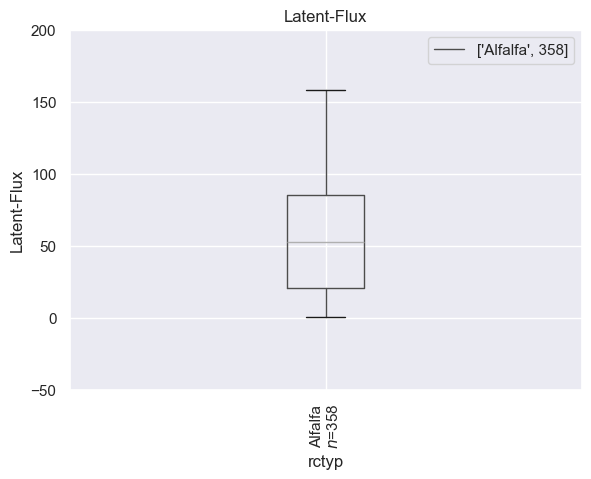

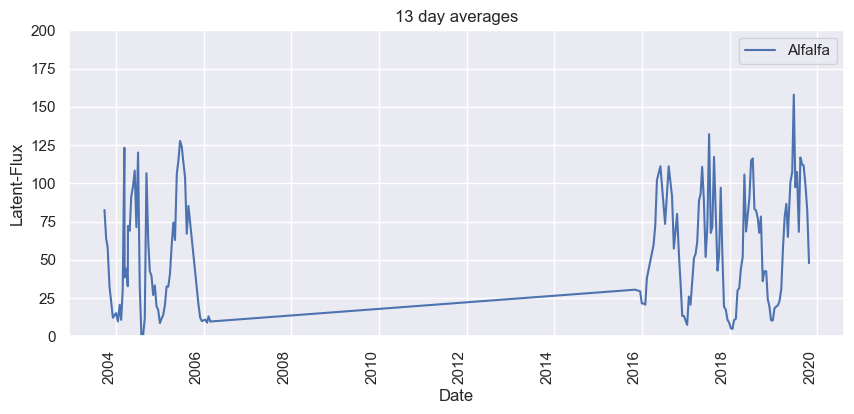

In [37]:
flux_type_1='Latent-Flux'
flux_type_2='CO2-Flux'
# group_type=['rowCropsTypeEc','rowCropsConditionEc']
if crop=='WW':
    group_type='wwh'
else:
    group_type='rctyp'
sns.set_theme('notebook')

# fig,ax=plt.subplots(2,1,figsize=(4.5,6))
cax=site_conditions.boxplot(column=flux_type_1,by=group_type,rot=90)
# site_conditions.boxplot(column=flux_type_2,by=group_type,rot=90,ax=ax[1])
# plt.suptitle('');ax[0].set_xlabel('');ax[0].set_xticklabels('');ax[1].set_xlabel('')
plt.suptitle('');plt.ylim([-50,200]);plt.ylabel(flux_type_1)
plt.title('{}'.format(flux_type_1))
dfg = site_conditions.groupby(group_type);counts = [[k,len(v)] for k, v in dfg];plt.legend(counts)
cax.set_xticklabels(['%s\n$n$=%d'%(k, len(v)) for k, v in dfg])


if crop!='WW':
    crop_1=site_conditions.rctyp.value_counts().index[0]
    site_croptype_1=site_conditions[site_conditions['rctyp']==crop_1]
    
    site_croptype_1=site_croptype_1.drop(site_croptype_1[np.isnan(site_croptype_1['Latent-Flux'])].index)
    site_croptype_1.plot('Date',flux_type_1,rot=90,figsize=(10,4.5))
    plt.ylabel(flux_type_1);plt.legend([crop_1]);plt.ylim([0,200]);
    plt.title('{} day averages'.format(interval))
else:
    crop_1='Winter Wheat'
    site_croptype_1=site_conditions[site_conditions['wwh']=='Yes']

    site_croptype_1=site_croptype_1.drop(site_croptype_1[np.isnan(site_croptype_1['Latent-Flux'])].index)
    site_croptype_1.plot('Date',flux_type_1,rot=90,figsize=(10,4.5))
    plt.ylabel(flux_type_1);plt.legend([crop_1]);plt.ylim([0,200]);
    plt.title('{} day averages'.format(interval))

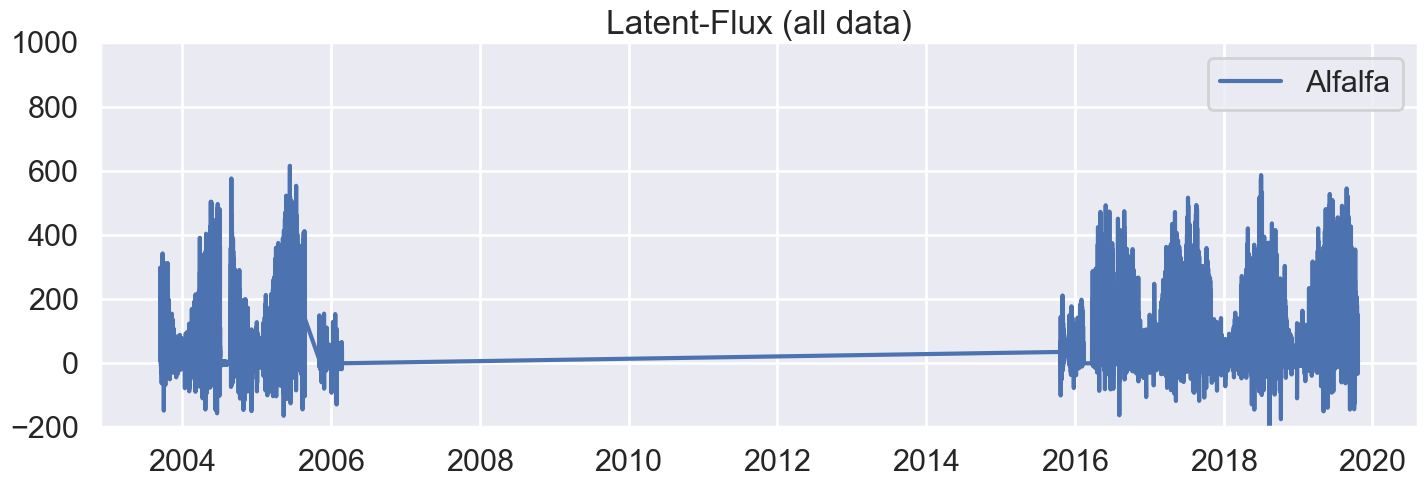

In [39]:
# del latent_flux_hourly_1
# del latent_flux_hourly_2
# del latent_flux_hourly_3
# del latent_flux_hourly_4
sns.set_theme('poster')

sites=site_croptype_1['Sitename'].values   

for k in range(0,len(site_croptype_1)): # len(site_croptype_1)
    site=sites[k]
    if site[2]==' ':
        sitename=site[0:2]
    else:
        sitename=site[0:3]
    if k==0:
        latent_flux_hourly_1=globals()['latent_flux_biweekly_{}_{}'.format(sitename,pd.to_datetime(site_croptype_1.Date.values)[k].strftime('%Y%m%d'))]
    else:
        latent_flux_hourly_1=xr.concat([latent_flux_hourly_1,globals()['latent_flux_biweekly_{}_{}'.format(sitename,pd.to_datetime(site_croptype_1.Date.values)[k].strftime('%Y%m%d'))]],'time')

fig,ax=plt.subplots(1,1,figsize=(17,5))
ax.plot(latent_flux_hourly_1.time,latent_flux_hourly_1)
ax.set_title('{} (all data)'.format(flux_type_1,interval))
ax.set_ylim([-200,1000]);ax.legend([crop_1])

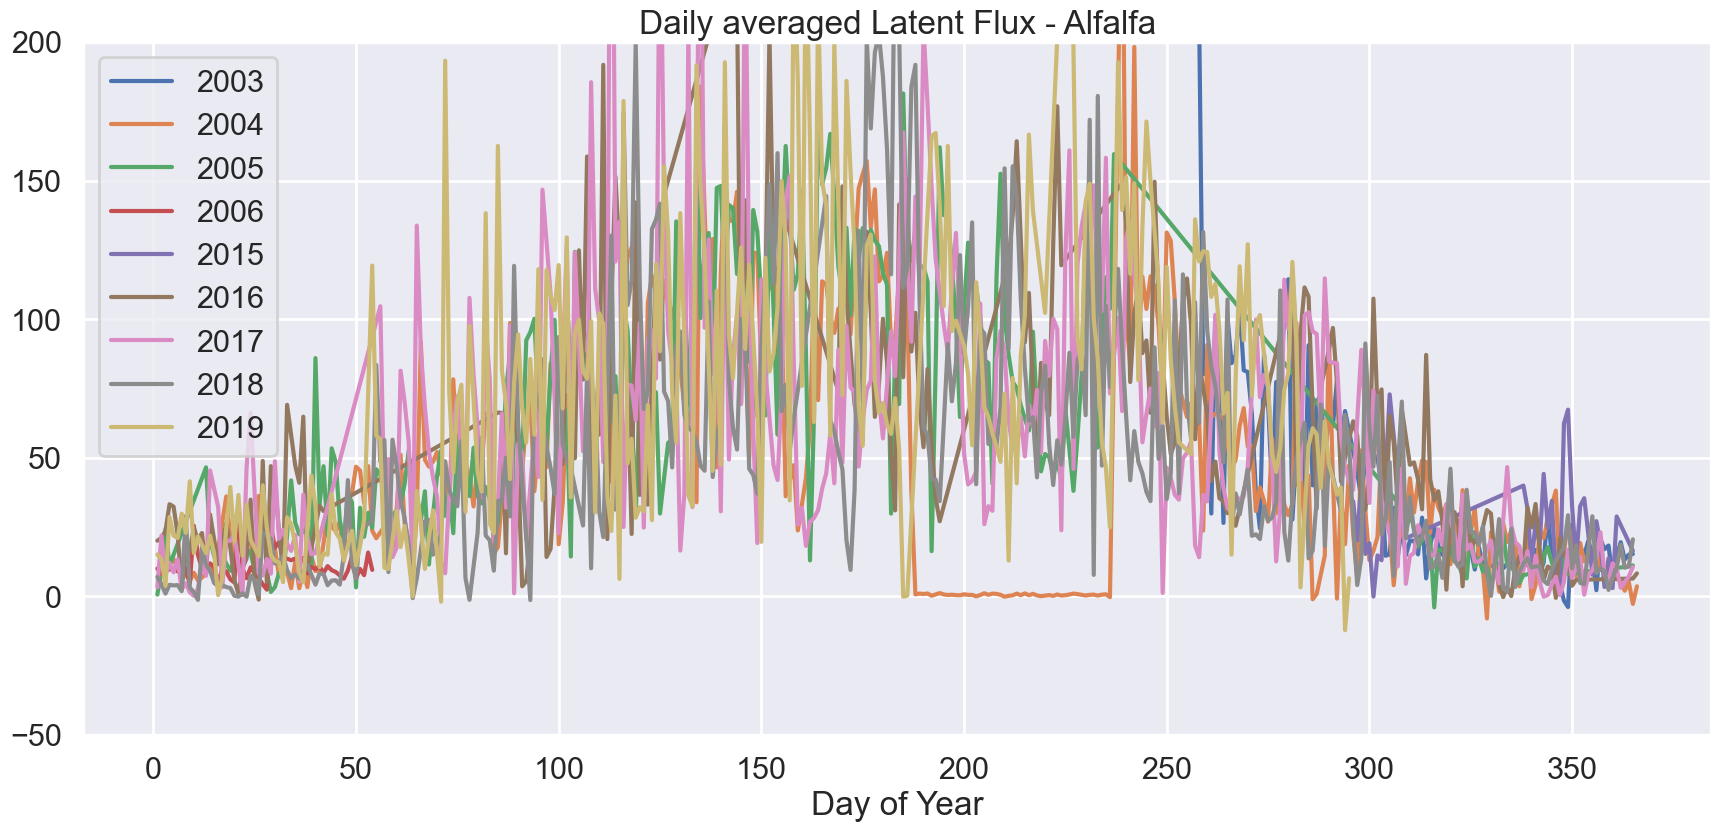

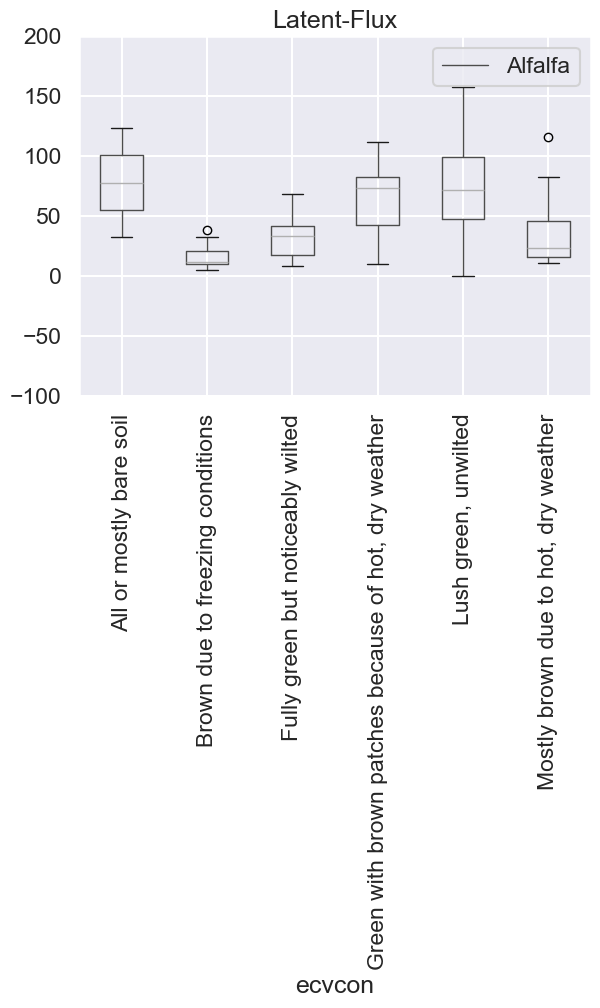

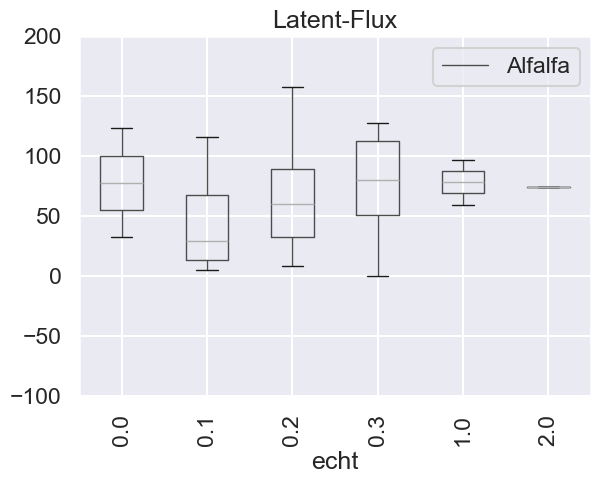

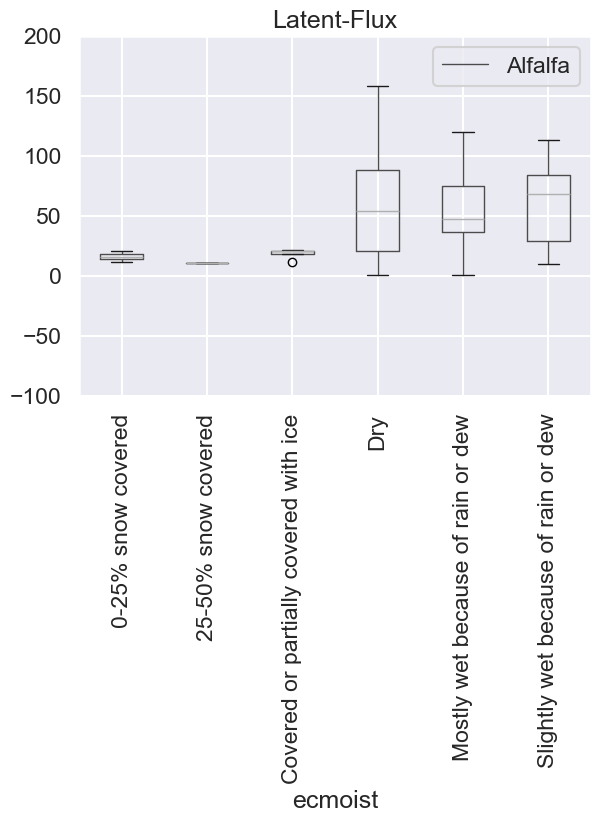

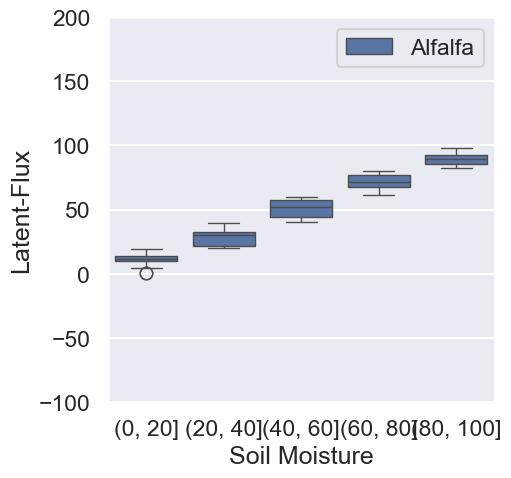

In [40]:
# plt.plot(latent_flux_hourly_1.time)
# plt.plot(latent_flux_hourly_1.time,latent_flux_hourly_1)
sns.set_theme('poster')

freq='daily' # 30min, daily, or monthly

fig,ax=plt.subplots(1,1,figsize=(21,9))
for k in range(0,len(list(latent_flux_hourly_1.groupby("time.year").groups))): # 
    globals()['year{}'.format(k)]=list(latent_flux_hourly_1.groupby("time.year").groups)[k]
    globals()['latent_flux_year{}'.format(k)]=latent_flux_hourly_1.groupby("time.year")[globals()['year{}'.format(k)]]
    globals()['latent_flux_year{}_daily'.format(k)]=globals()['latent_flux_year{}'.format(k)].groupby("time.dayofyear").mean()
    globals()['latent_flux_year{}_monthly'.format(k)]=globals()['latent_flux_year{}'.format(k)].groupby("time.month").mean()
    if freq=='30min':
        plt.plot(globals()['latent_flux_year{}'.format(k)]['time.dayofyear'],globals()['latent_flux_year{}'.format(k)])
        plt.xlabel('Day of Year');plt.title('30-min averaged Latent Flux - {}'.format(crop_1))
    elif freq=='daily':
        plt.plot(globals()['latent_flux_year{}_daily'.format(k)]['dayofyear'],globals()['latent_flux_year{}_daily'.format(k)])
        plt.xlabel('Day of Year');plt.title('Daily averaged Latent Flux - {}'.format(crop_1))
    elif freq=='monthly':
        plt.plot(globals()['latent_flux_year{}_monthly'.format(k)]['month'],globals()['latent_flux_year{}_monthly'.format(k)])
        plt.xlabel('Month');plt.title('Monthly averaged Latent Flux - {}'.format(crop_1))    
    labels = [l for l in list(latent_flux_hourly_1.groupby("time.year").groups)]
    plt.legend(labels)
    plt.ylim([-50,200])

if crop=='WW':
    flux_type_1='Latent-Flux'
    group_type='wwhlst'
    sns.set_theme('talk')
    # ax.get_legend().remove()
    site_croptype_1.boxplot(column=flux_type_1,by=group_type,rot=90)
    plt.suptitle('')
    plt.ylim([-100,200]);plt.legend([crop_1])
    
    fig,ax=plt.subplots(1,1,figsize=(5,5))
    flux_type_1='Latent-Flux'
    group_type='Soil-Moisture(%)'
    sns.set_theme('talk')
    # ax.get_legend().remove()
    #     site_croptype_1.boxplot(column=flux_type_1,by=group_type,rot=90, bins=range(0, 101, 20))
    df=site_croptype_1
    df['Soil Moisture'] = pd.cut(df[flux_type_1], bins=range(0, 101, 20))
    ax = sns.boxplot(x="Soil Moisture", y=flux_type_1, data=df)
    plt.suptitle('')
    plt.ylim([-100,200]);plt.legend([crop_1])    
else:
    flux_type_1='Latent-Flux'
    group_type='ecvcon'
    sns.set_theme('talk')
    # ax.get_legend().remove()
    site_croptype_1.boxplot(column=flux_type_1,by=group_type,rot=90)
    plt.suptitle('')
    plt.ylim([-100,200]);plt.legend([crop_1])

    flux_type_1='Latent-Flux'
    group_type='echt'
    sns.set_theme('talk')
    # ax.get_legend().remove()
    site_croptype_1.boxplot(column=flux_type_1,by=group_type,rot=90)
    plt.suptitle('')
    plt.ylim([-100,200]);plt.legend([crop_1])

    flux_type_1='Latent-Flux'
    group_type='ecmoist'
    sns.set_theme('talk')
    # ax.get_legend().remove()
    site_croptype_1.boxplot(column=flux_type_1,by=group_type,rot=90)
    plt.suptitle('')
    plt.ylim([-100,200]);plt.legend([crop_1])
    
    fig,ax=plt.subplots(1,1,figsize=(5,5))
    flux_type_1='Latent-Flux'
    group_type='Soil-Moisture(%)'
    sns.set_theme('talk')
    # ax.get_legend().remove()
#     site_croptype_1.boxplot(column=flux_type_1,by=group_type,rot=90)
    df=site_croptype_1
    df['Soil Moisture'] = pd.cut(df[flux_type_1], bins=range(0, 101, 20))
    ax = sns.boxplot(x="Soil Moisture", y=flux_type_1, data=df)
    plt.suptitle('')
    plt.ylim([-100,200]);plt.legend([crop_1])

In [8]:
# ndvi_df=pd.read_csv(r'C:\Users\sid.gupta\Documents\data\fluxes\site_conditions_ndvi_{}.csv'.format(crop))

# ndvi_df=ndvi_df.sort_values(by=['FluxPM_Date'])
# ndvi_df=ndvi_df.drop_duplicates()
# ndvi_df['FluxPM_Date'].values

In [9]:
# for k in range(0,len(site_croptype_1)): # len(site_croptype_1)
#     ind=site_croptype_1.index[k]
#     site_croptype_1.at[k,'NDVI_mean'] = np.nanmax(ndvi_df[ndvi_df['FluxPM_Date'] == pd.to_datetime(site_croptype_1['Date'][k:k+1].values[0]).strftime('%Y-%m-%d')]['NDVI_mean'].values)

In [10]:
# site_croptype_1.loc[k,'NDVI_mean'] = ndvi_df[ndvi_df['FluxPM_Date'] == pd.to_datetime(site_croptype_1['Date'][k:k+1].values[0]).strftime('%Y-%m-%d')]['NDVI_mean'].values[0]

In [11]:
# flux_type_1='NDVI_mean'
# group_type='ecvcon'
# sns.set_theme('talk')
# # ax.get_legend().remove()
# site_croptype_1.boxplot(column=flux_type_1,by=group_type,rot=90)
# plt.suptitle('')
# plt.ylim([-1,1]);plt.legend([crop_1])
